In [387]:
# parse aggregate results
import os
import sys
from tensorflow.compat.v1 import gfile

sys.path.append(os.path.abspath("/home/mwu34/disentanglement_lib"))
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

### double_descent_study_v2: plot metrics against scale

In [159]:
df = pd.read_json("/home/mwu34/disentanglement_lib/results.json")
print(df.shape)

In [155]:
# sorted(df[df['train_config.vae.beta'] == 8]['train_config.deconv_decoder.num_parameters_scale'].unique() * 32 - 1 + 64)

In [152]:
def plot_metric_against_scale(df, column_names, map_column_names_to_ylabels, beta_values):
    """for each column in column_names, create a subfigure against scale"""
    fig_row_length = (len(column_names) + 1) // 2
    fig, axs = plt.subplots(fig_row_length, 2, figsize=(10, 10))
    for subplot_idx, col in enumerate(column_names):
        ax = axs[subplot_idx // 2, subplot_idx % 2]
        for beta in beta_values:
            df_cleaned = df[
                (df['postprocess_config.postprocess.name'] == "'mean'")
                & (df['train_config.vae.beta'] == beta)
                & (df[col].notna())
            ].sort_values('train_config.deconv_decoder.num_parameters_scale')
            ax.plot(
                df_cleaned['train_config.deconv_decoder.num_parameters_scale'],
                df_cleaned[col]
            )
        ax.set_ylabel(map_column_names_to_ylabels[col])
        ax.set_xlabel('scale')
    axs[0, 0].legend(beta_values)
        


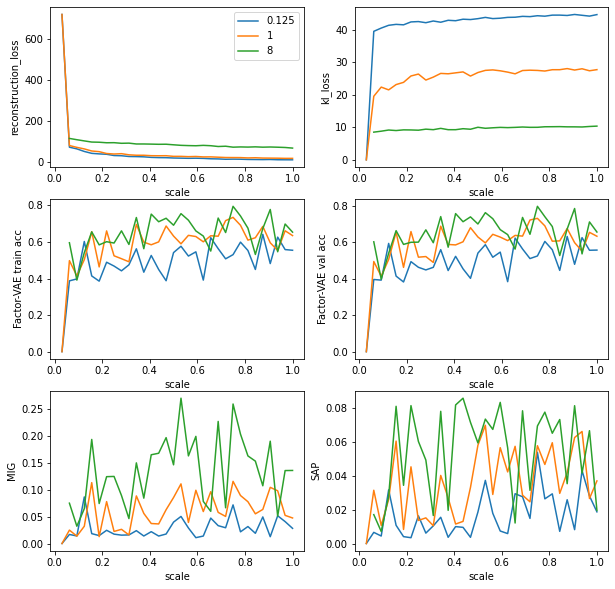

In [153]:
column_names = [
    'train_results.reconstruction_loss',
    'train_results.kl_loss',
    'evaluation_results.train_accuracy', # factor-VAE
    'evaluation_results.eval_accuracy', # factor-VAE
    'evaluation_results.discrete_mig', # MIG
    'evaluation_results.SAP_score', # SAP
]
map_column_names_to_ylabels = {
    'train_results.reconstruction_loss': 'reconstruction_loss',
    'train_results.kl_loss': 'kl_loss',
    'evaluation_results.train_accuracy': 'Factor-VAE train acc', # factor-VAE
    'evaluation_results.eval_accuracy': 'Factor-VAE val acc', # factor-VAE
    'evaluation_results.discrete_mig': 'MIG', # MIG
    'evaluation_results.SAP_score': 'SAP', # SAP
}
plot_metric_against_scale(df, column_names, map_column_names_to_ylabels, beta_values=[0.125, 1, 8])

### study_v3: plot validation loss against timesteps

In [224]:
df = pd.read_json("/home/mwu34/disentanglement_lib/results_v3.json")
print(df.shape)

(96, 1220)


In [225]:
def plot_loss_against_timestep(df, column_names, beta_value):
    """for each column in column_names, create a subfigure against scale"""
    fig, axs = plt.subplots(len(column_names), 1, figsize=(10, 10))
    timesteps = list(range(10000, 300001, 10000))
    # scales = sorted(df['valid_final_config.deconv_decoder.num_parameters_scale'].unique())
    scales = [i / 32. for i in range(2, 10)]
    for subplot_idx, col in enumerate(column_names):
        ax = axs[subplot_idx]
        for scale in scales:
            losses = [
                df[
                    (df['valid_final_config.vae.beta'] == beta_value)
                    & (df['valid_final_config.deconv_decoder.num_parameters_scale'] == scale)
                ][f"valid{t}_results.{col}"]
                for t in timesteps
            ]
            ax.plot(timesteps, losses)
        ax.set_ylabel(col)
        ax.set_xlabel('timesteps')
    axs[0].legend(scales)

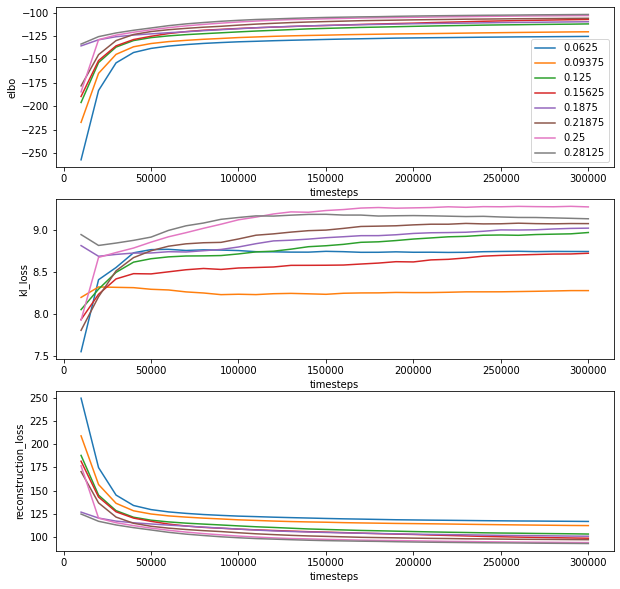

In [227]:
# blue line (scale = 2/32) has a different kl_loss shape
column_names = ['elbo', 'kl_loss', 'reconstruction_loss']
plot_loss_against_timestep(df, column_names, beta_value=8)

### study_v3: plot loss against scale

In [228]:
def plot_loss_against_scale(df, column_names, beta_value):
    """for each column in column_names, create a subfigure against scale"""
    fig, axs = plt.subplots(len(column_names), 1, figsize=(10, 10))
    timesteps = list(range(10000, 130001, 10000)) + ['_final']
    # scales = sorted(df['valid_final_config.deconv_decoder.num_parameters_scale'].unique())
    scales = [i / 32. for i in range(2, 33)]
    for subplot_idx, col in enumerate(column_names):
        ax = axs[subplot_idx]
        for t in timesteps:
            losses = [
                df[
                    (df['valid_final_config.vae.beta'] == beta_value)
                    & (df['valid_final_config.deconv_decoder.num_parameters_scale'] == scale)
                ][f"valid{t}_results.{col}"]
                for scale in scales
            ]
            ax.plot(scales, losses)
        ax.set_ylabel(col)
        ax.set_xlabel('scale')
    axs[0].legend(timesteps)


/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe7cb728410> has a label of '_final' which cannot be automatically added to the legend.


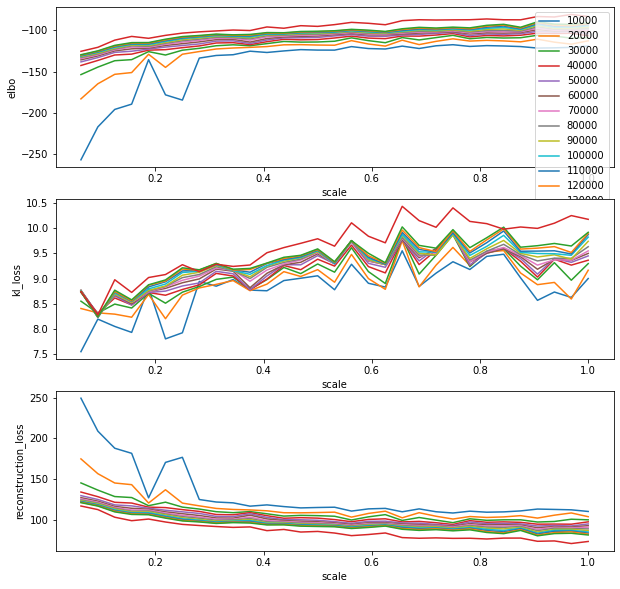

In [230]:
# super low kl_loss at scale = 1/32
# weird kl_loss increase at scale = 2/32
# not plotting scale = 1/32 cuz so different from other values

column_names = ['elbo', 'kl_loss', 'reconstruction_loss']
plot_loss_against_scale(df, column_names, beta_value=8)

### study_v4: plot loss against num_latent

In [333]:
df = pd.read_json("/home/mwu34/disentanglement_lib/results_v4.json")
print(df.shape)

(24, 1220)


In [334]:
def plot_loss_against_num_latent(df, column_names, beta_value):
    """for each column in column_names, create a subfigure against scale"""
    fig, axs = plt.subplots(len(column_names), 1, figsize=(10, 10))
    latent_units = sorted(df['valid_final_config.encoder.num_latent'].unique())
    timesteps = [str(elm) for elm in range(10000, 250001, 10000)] + ['_final']
    cmap_gradient = [cm.autumn(int(256 * color)) for color in np.linspace(0.2, 0.8, len(timesteps))]
    for subplot_idx, col in enumerate(column_names):
        ax = axs[subplot_idx]
        for c_idx, t in enumerate(timesteps):
            losses = [
                df[
                    (df['valid_final_config.vae.beta'] == beta_value)
                    & (df['valid_final_config.encoder.num_latent'] == latent)
                ][f"valid{t}_results.{col}"]
                for latent in latent_units
            ]
            ax.plot(latent_units, losses, c=cmap_gradient[c_idx])
        ax.set_ylabel(col)
        ax.set_xlabel('num latent units')
    axs[0].legend(timesteps)


/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe7d15b3cd0> has a label of '_final' which cannot be automatically added to the legend.


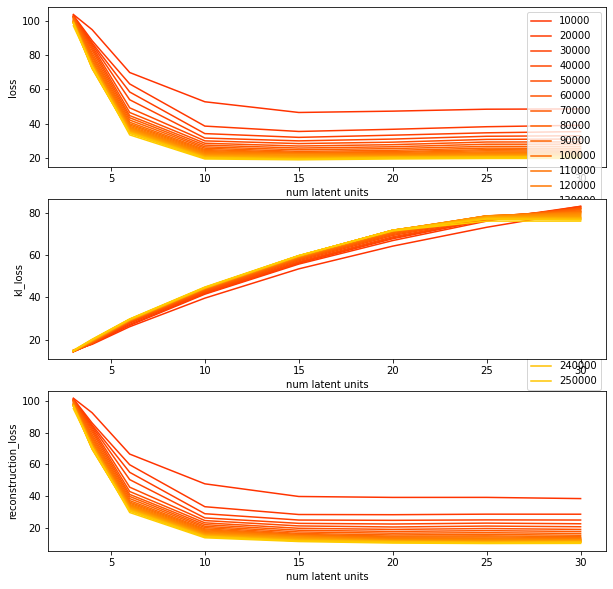

In [335]:
# super low kl_loss at scale = 1/32
# weird kl_loss increase at scale = 2/32
# not plotting scale = 1/32 cuz so different from other values

column_names = ['loss', 'kl_loss', 'reconstruction_loss']
plot_loss_against_num_latent(df, column_names, beta_value=0.125)

### study_v5: plot loss against num_latent (super small train set)

In [294]:
df = pd.read_json("/home/mwu34/disentanglement_lib/results_v5.json")
print(df.shape)

(24, 308)


In [307]:
def plot_loss_against_num_latent(df, column_names, beta_value):
    """for each column in column_names, create a subfigure against scale"""
    fig, axs = plt.subplots(len(column_names), 1, figsize=(10, 10))
    latent_units = sorted(df['valid_final_config.encoder.num_latent'].unique())
    timesteps = [str(elm) for elm in range(10000, 60001, 10000)] + ['_final']
    cmap_gradient = [cm.autumn(int(256 * color)) for color in np.linspace(0.2, 0.8, len(timesteps))]
    for subplot_idx, col in enumerate(column_names):
        ax = axs[subplot_idx]
        for c_idx, t in enumerate(timesteps):
            losses = [
                df[
                    (df['valid_final_config.vae.beta'] == beta_value)
                    & (df['valid_final_config.encoder.num_latent'] == latent)
                ][f"valid{t}_results.{col}"]
                for latent in latent_units
            ]
            ax.plot(latent_units, losses, c=cmap_gradient[c_idx])
        # plot training loss
        train_losses = [
            df[
                (df['valid_final_config.vae.beta'] == beta_value)
                & (df['valid_final_config.encoder.num_latent'] == latent)
            ][f"train_final_results.{col}"]
            for latent in latent_units
        ]
        ax.plot(latent_units, train_losses, c='blue')
        ax.set_ylabel(col)
        ax.set_xlabel('num latent units')
    axs[0].legend(timesteps + ['train_loss'])


/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe7d00153d0> has a label of '_final' which cannot be automatically added to the legend.


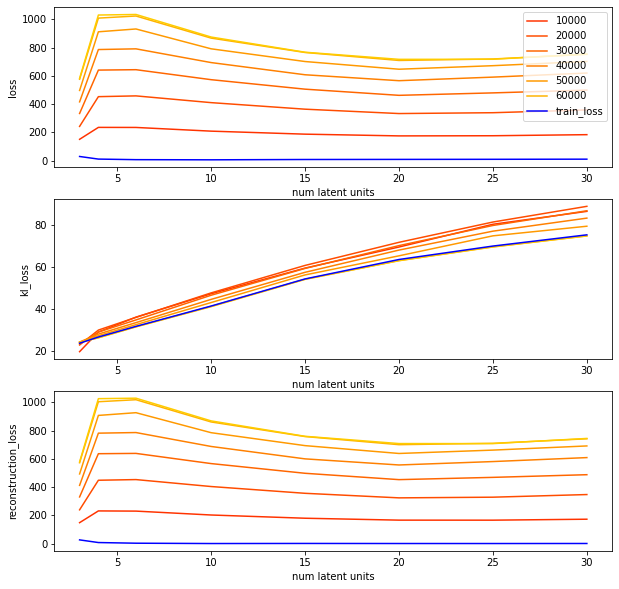

In [311]:
# super low kl_loss at scale = 1/32
# weird kl_loss increase at scale = 2/32
# not plotting scale = 1/32 cuz so different from other values

column_names = ['loss', 'kl_loss', 'reconstruction_loss']
plot_loss_against_num_latent(df, column_names, beta_value=0.125)

### study_v6: plot loss against num_latent (super small train set)

In [339]:
df = pd.read_json("/home/mwu34/disentanglement_lib/results_v6.json")
print(df.shape)

(42, 536)


In [340]:
def plot_loss_against_num_latent(df, column_names, beta_value):
    """for each column in column_names, create a subfigure against scale"""
    fig, axs = plt.subplots(len(column_names), 1, figsize=(10, 10))
    latent_units = sorted(df['valid_final_config.encoder.num_latent'].unique())
    timesteps = [str(elm) for elm in range(10000, 60001, 10000)] + ['_final']
    valid_color_gradient = [cm.autumn(int(256 * color)) for color in np.linspace(0.2, 0.8, len(timesteps))]
    train_color_gradient = [cm.winter(int(256 * color)) for color in np.linspace(0.2, 0.8, len(timesteps))]
    
    for subplot_idx, col in enumerate(column_names):
        ax = axs[subplot_idx]
        for c_idx, t in enumerate(timesteps):
            # validation loss
            valid_losses = [
                df[
                    (df['valid_final_config.vae.beta'] == beta_value)
                    & (df['valid_final_config.encoder.num_latent'] == latent)
                ][f"valid{t}_results.{col}"]
                for latent in latent_units
            ]
            ax.plot(latent_units, valid_losses, c=valid_color_gradient[c_idx])
        for c_idx, t in enumerate(timesteps):
            # training loss
            train_losses = [
                df[
                    (df['valid_final_config.vae.beta'] == beta_value)
                    & (df['valid_final_config.encoder.num_latent'] == latent)
                ][f"train{t}_results.{col}"]
                for latent in latent_units
            ]
            ax.plot(latent_units, train_losses, c=train_color_gradient[c_idx])
        ax.set_ylabel(col)
        ax.set_xlabel('num latent units')
    legend = ['valid_' + t for t in timesteps[:-1]] \
        + ['valid_final'] \
        + ['train_' + t for t in timesteps[:-1]] \
        + ['train_final']
    axs[0].legend(legend)
    axs[0].axvline(x=5, color='black')


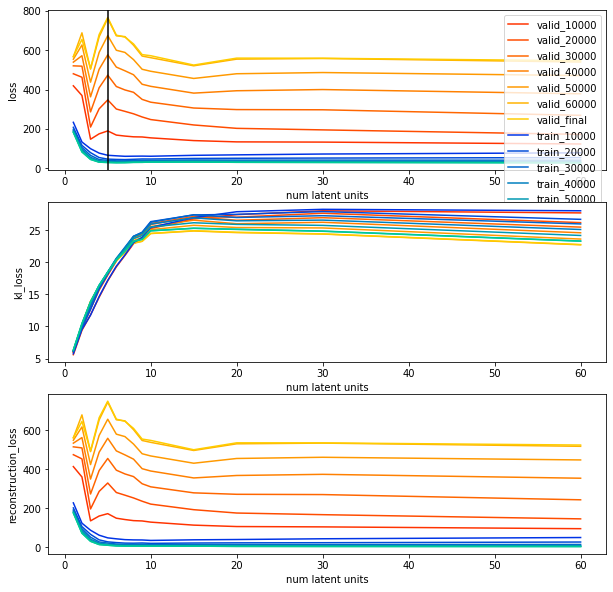

In [343]:
# super low kl_loss at scale = 1/32
# weird kl_loss increase at scale = 2/32
# not plotting scale = 1/32 cuz so different from other values

column_names = ['loss', 'kl_loss', 'reconstruction_loss']
plot_loss_against_num_latent(df, column_names, beta_value=1)

### study_v7: plot loss against num_latent (super small train set)

In [440]:
df = pd.read_json("/home/mwu34/disentanglement_lib/results_v7.json")
print(df.shape)

(144, 536)


In [441]:
def plot_loss_against_num_latent(df, column_names, beta_value, num_training_data):
    """for each column in column_names, create a subfigure against scale"""
    fig, axs = plt.subplots(len(column_names), 1, figsize=(10, 10))
    latent_units = sorted(df['valid_final_config.encoder.num_latent'].unique())
    timesteps = [str(elm) for elm in range(10000, 60001, 10000)] + ['_final']
    valid_color_gradient = [cm.autumn(int(256 * color)) for color in np.linspace(0.2, 0.8, len(timesteps))]
    train_color_gradient = [cm.winter(int(256 * color)) for color in np.linspace(0.2, 0.8, len(timesteps))]
    
    for subplot_idx, col in enumerate(column_names):
        ax = axs[subplot_idx]
        for c_idx, t in enumerate(timesteps):
            # validation loss
            valid_losses = [
                df[
                    (df['valid_final_config.vae.beta'] == beta_value)
                    & (df['valid_final_config.dataset.num_training_data'] == num_training_data)
                    & (df['valid_final_config.encoder.num_latent'] == latent)
                ][f"valid{t}_results.{col}"]
                for latent in latent_units
            ]
            ax.plot(latent_units, valid_losses, c=valid_color_gradient[c_idx])
        for c_idx, t in enumerate(timesteps):
            # training loss
            train_losses = [
                df[
                    (df['valid_final_config.vae.beta'] == beta_value)
                    & (df['valid_final_config.dataset.num_training_data'] == num_training_data)
                    & (df['valid_final_config.encoder.num_latent'] == latent)
                ][f"train{t}_results.{col}"]
                for latent in latent_units
            ]
            # ax.plot(latent_units, train_losses, c=train_color_gradient[c_idx])
        ax.set_ylabel(col)
        ax.set_xlabel('num latent units')
    legend = ['valid_' + t for t in timesteps[:-1]] \
        + ['valid_final'] \
        + ['train_' + t for t in timesteps[:-1]] \
        + ['train_final']
    axs[0].legend(legend)
    axs[0].axvline(x=3, color='black')


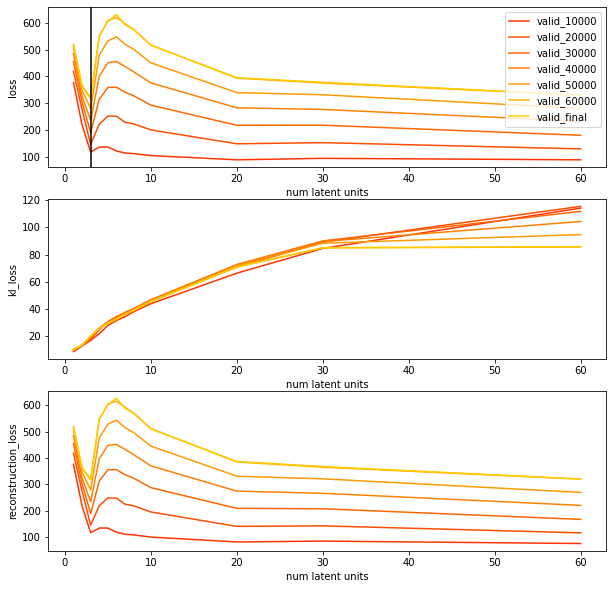

In [442]:
# super low kl_loss at scale = 1/32
# weird kl_loss increase at scale = 2/32
# not plotting scale = 1/32 cuz so different from other values

column_names = ['loss', 'kl_loss', 'reconstruction_loss']
plot_loss_against_num_latent(df, column_names, beta_value=0.125, num_training_data=1000)

### study_v7: plot metrics

In [461]:
df_train = pd.read_json("/home/mwu34/disentanglement_lib/results_v7_metrics_mean_train.json")
df_valid = pd.read_json("/home/mwu34/disentanglement_lib/results_v7_metrics_mean_valid.json")
print(df_train.shape)
print(df_valid.shape)

(194, 572)
(194, 572)


In [470]:
def plot_metric_against_num_latent(df_train, df_valid, column_names, beta_value, num_training_data):
    """for each column in column_names, create a subfigure against scale"""
    fig, axs = plt.subplots(len(column_names), 1, figsize=(10, 10))
    latent_units = sorted(df['valid_final_config.encoder.num_latent'].unique())
    num_training_points = [1000, 3000, 5000, 7000]
    train_color_gradient = [cm.autumn(int(256 * color)) for color in np.linspace(0.2, 0.8, len(num_training_points))]
    valid_color_gradient = [cm.winter(int(256 * color)) for color in np.linspace(0.2, 0.8, len(num_training_points))]
    legend = []
    for subplot_idx, col in enumerate(column_names):
        for train_idx, num_training_data in enumerate(num_training_points):
            ax = axs[subplot_idx]
            # mean_train
            metrics = [
                df_train[
                    (df_train['valid_final_config.vae.beta'] == beta_value)
                    & (df_train['valid_final_config.dataset.num_training_data'] == num_training_data)
                    & (df_train['valid_final_config.encoder.num_latent'] == latent)
                    & (df_train[col].notna())
                ][col]
                for latent in latent_units
            ]
            ax.plot(latent_units, metrics, color=train_color_gradient[train_idx])
            legend.append(f'train_{num_training_data}')
            # mean_valid
            metrics = [
                df_valid[
                    (df_valid['valid_final_config.vae.beta'] == beta_value)
                    & (df_valid['valid_final_config.dataset.num_training_data'] == num_training_data)
                    & (df_valid['valid_final_config.encoder.num_latent'] == latent)
                    & (df_valid[col].notna())
                ][col]
                for latent in latent_units
            ]
            # ax.plot(latent_units, metrics, color=valid_color_gradient[train_idx])
            # legend.append(f'valid_{num_training_data}')
            
        ax.set_ylabel(col)
        ax.set_xlabel('num latent units')
    axs[0].legend(legend)
    axs[0].axvline(x=3, color='black')


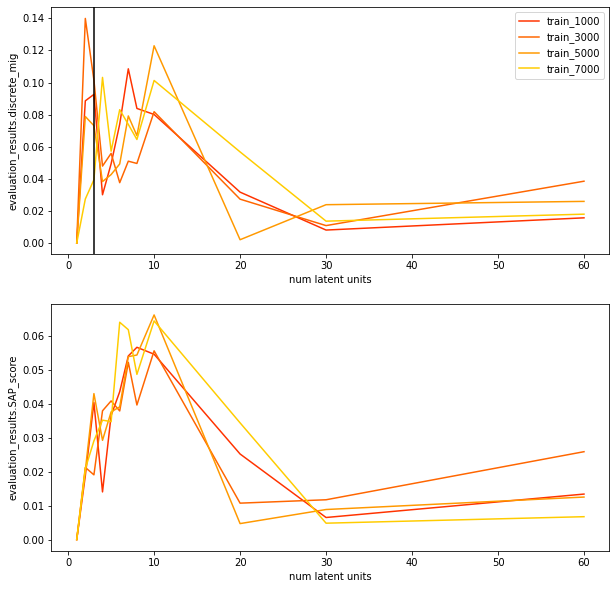

In [471]:
# super low kl_loss at scale = 1/32
# weird kl_loss increase at scale = 2/32
# not plotting scale = 1/32 cuz so different from other values

column_names = ['evaluation_results.discrete_mig', 'evaluation_results.SAP_score']
plot_metric_against_num_latent(df_train, df_valid, column_names, beta_value=1, num_training_data=1000)

### study_v8: why does validation loss increase over time

In [425]:
df = pd.read_json("/home/mwu34/disentanglement_lib/results_v8.json")
print(df.shape)

(72, 2360)


In [426]:
def plot_loss_against_num_latent(df, column_names, beta_value, num_training_data):
    """for each column in column_names, create a subfigure against scale"""
    fig, axs = plt.subplots(len(column_names), 1, figsize=(10, 10))
    latent_units = sorted(df['valid_final_config.encoder.num_latent'].unique())
    timesteps = [str(elm) for elm in range(10000, 30001, 1000)] + ['_final']
    valid_color_gradient = [cm.autumn(int(256 * color)) for color in np.linspace(0.2, 0.8, len(timesteps))]
    train_color_gradient = [cm.winter(int(256 * color)) for color in np.linspace(0.2, 0.8, len(timesteps))]
    
    for subplot_idx, col in enumerate(column_names):
        ax = axs[subplot_idx]
        for c_idx, t in enumerate(timesteps):
            # validation loss
            valid_losses = [
                df[
                    (df['valid_final_config.vae.beta'] == beta_value)
                    & (df['valid_final_config.dataset.num_training_data'] == num_training_data)
                    & (df['valid_final_config.encoder.num_latent'] == latent)
                ][f"valid{t}_results.{col}"]
                for latent in latent_units
            ]
            ax.plot(latent_units, valid_losses, c=valid_color_gradient[c_idx])
        for c_idx, t in enumerate(timesteps):
            # training loss
            train_losses = [
                df[
                    (df['valid_final_config.vae.beta'] == beta_value)
                    & (df['valid_final_config.dataset.num_training_data'] == num_training_data)
                    & (df['valid_final_config.encoder.num_latent'] == latent)
                ][f"train{t}_results.{col}"]
                for latent in latent_units
            ]
            # ax.plot(latent_units, train_losses, c=train_color_gradient[c_idx])
        ax.set_ylabel(col)
        ax.set_xlabel('num latent units')
    legend = ['valid_' + t for t in timesteps[:-1]] \
        + ['valid_final'] \
        + ['train_' + t for t in timesteps[:-1]] \
        + ['train_final']
    axs[0].legend(legend)
    axs[0].axvline(x=3, color='black')


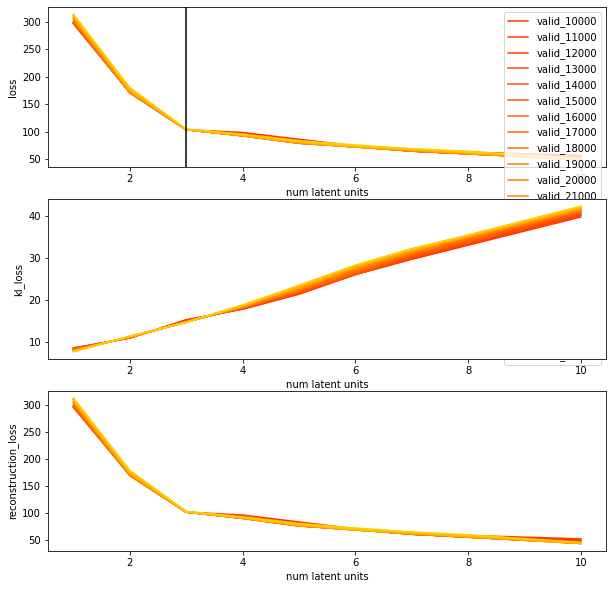

In [434]:
# super low kl_loss at scale = 1/32
# weird kl_loss increase at scale = 2/32
# not plotting scale = 1/32 cuz so different from other values

column_names = ['loss', 'kl_loss', 'reconstruction_loss']
plot_loss_against_num_latent(df, column_names, beta_value=0.125, num_training_data=5000)

In [435]:
def plot_loss_against_timesteps(df, column_names, beta_value, num_training_data):
    """for each column in column_names, create a subfigure against scale"""
    fig, axs = plt.subplots(len(column_names), 1, figsize=(10, 10))
    latent_units = sorted(df['valid_final_config.encoder.num_latent'].unique())
    timesteps = [str(elm) for elm in range(10000, 30001, 1000)] + ['_final']
    print(latent_units)
    print(timesteps)
    valid_color_gradient = [cm.autumn(int(256 * color)) for color in np.linspace(0.2, 0.8, len(latent_units))]
    train_color_gradient = [cm.winter(int(256 * color)) for color in np.linspace(0.2, 0.8, len(latent_units))]
    
    for subplot_idx, col in enumerate(column_names):
        ax = axs[subplot_idx]
        for c_idx, latent in enumerate(latent_units):
            # validation loss
            valid_losses = [
                df[
                    (df['valid_final_config.vae.beta'] == beta_value)
                    & (df['valid_final_config.dataset.num_training_data'] == num_training_data)
                    & (df['valid_final_config.encoder.num_latent'] == latent)
                ][f"valid{t}_results.{col}"]
                for t in timesteps
            ]
            ax.plot(timesteps, valid_losses, c=valid_color_gradient[c_idx])
        for c_idx, latent in enumerate(latent_units):
            # training loss
            train_losses = [
                df[
                    (df['valid_final_config.vae.beta'] == beta_value)
                    & (df['valid_final_config.dataset.num_training_data'] == num_training_data)
                    & (df['valid_final_config.encoder.num_latent'] == latent)
                ][f"train{t}_results.{col}"]
                for t in timesteps
            ]
            ax.plot(timesteps, train_losses, c=train_color_gradient[c_idx])
        ax.set_ylabel(col)
        ax.set_xlabel('timesteps')
    legend = latent_units
    axs[0].legend(legend)
    # axs[0].axvline(x=3, color='black')



[1, 2, 3, 4, 5, 6, 7, 8, 10]
['10000', '11000', '12000', '13000', '14000', '15000', '16000', '17000', '18000', '19000', '20000', '21000', '22000', '23000', '24000', '25000', '26000', '27000', '28000', '29000', '30000', '_final']


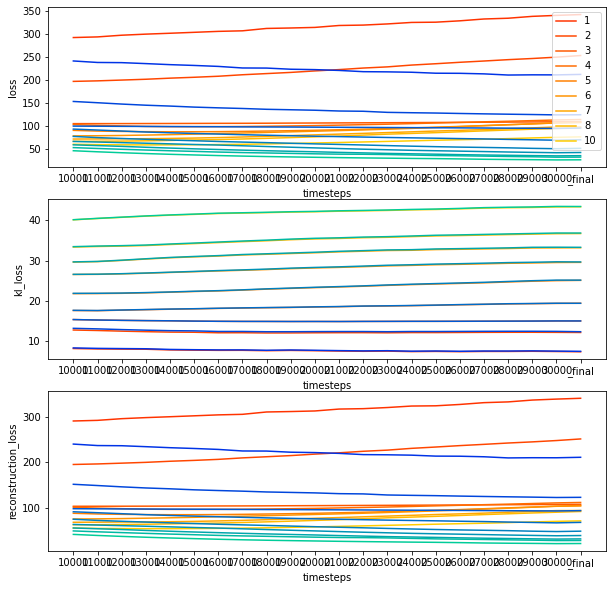

In [439]:
column_names = ['loss', 'kl_loss', 'reconstruction_loss']
plot_loss_against_timesteps(df, column_names, beta_value=0.125, num_training_data=3000)

### check factor-VAE train and validation accuracy difference

In [119]:
# factor VAE train and val acc are different but really close

df_cleaned = df[
    (df['postprocess_config.postprocess.name'] == "'mean'")
    & (df['train_config.vae.beta'] == 0.125)
    & (df['evaluation_results.train_accuracy'].notna())
].sort_values('train_config.deconv_decoder.num_parameters_scale')
df_cleaned[['evaluation_results.train_accuracy', 'evaluation_results.eval_accuracy']]

,evaluation_results.train_accuracy,evaluation_results.eval_accuracy
244,0.0000,0.0000
356,0.3872,0.3966
268,0.3977,0.3932
372,0.6025,0.5948
172,0.4140,0.4152
100,0.3857,0.3830
380,0.4890,0.4946
52,0.4681,0.4636
36,0.4420,0.4492
116,0.4748,0.4634
